In [805]:
# PyTorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Image datasets and image manipulation
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchvision.utils import save_image
import wandb


# Image display
import matplotlib.pyplot as plt
import numpy as np
import random

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
%matplotlib inline

In [611]:
train_dataset_path = '../dataset/handwritten_math_symbols/train/'
eval_dataset_path = '../dataset/handwritten_math_symbols/eval/'

In [673]:
model_input_shape = (32, 32)
train_dataset_transform = transforms.Compose([
    transforms.Resize((model_input_shape[0]+4, model_input_shape[0]+4)),
    transforms.RandomCrop((model_input_shape)),
    transforms.Grayscale(1),
    transforms.ToTensor(),
#     transforms.Lambda(lambd=lambda x: 1 - x),
    transforms.RandomRotation(10, fill=1),
#     transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])
eval_dataset_transform = transforms.Compose([
    transforms.Resize(model_input_shape),
    transforms.Grayscale(1),
    transforms.ToTensor(),
#     transforms.Lambda(lambd=lambda x: 1 - x),
#     transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

In [674]:
train_dataset = torchvision.datasets.ImageFolder(root=train_dataset_path, transform=train_dataset_transform)
eval_dataset = torchvision.datasets.ImageFolder(root=eval_dataset_path, transform=eval_dataset_transform)

In [675]:
assert len(train_dataset.classes) == len(eval_dataset.classes)

In [676]:
from collections import Counter
dict(Counter(train_dataset.targets)).values(), train_dataset.class_to_idx.keys()

(dict_values([513, 544, 429, 554, 431, 431, 549, 430, 432, 545, 430, 429, 429, 555, 430, 426]),
 dict_keys(['decimal', 'div', 'eight', 'equal', 'five', 'four', 'minus', 'nine', 'one', 'plus', 'seven', 'six', 'three', 'times', 'two', 'zero']))

<BarContainer object of 16 artists>

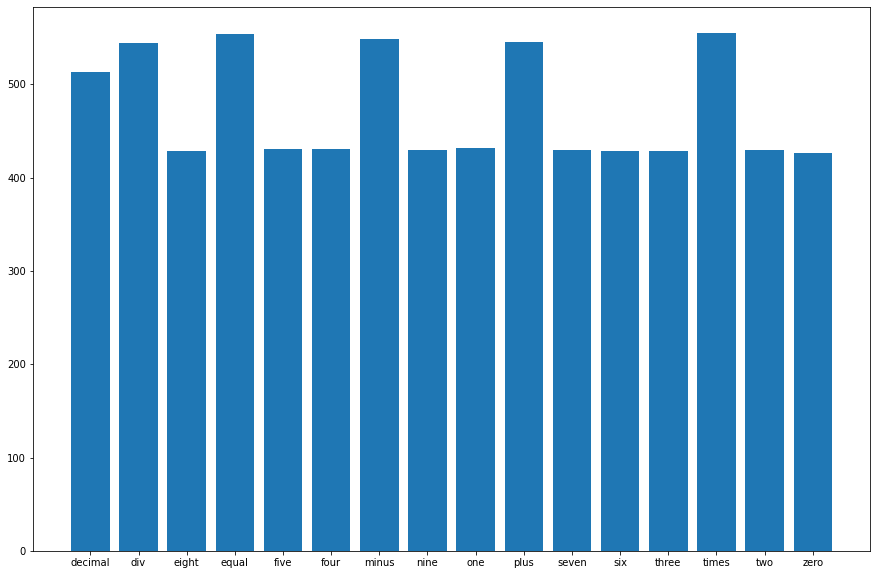

In [677]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.bar(list(train_dataset.class_to_idx.keys()),list(dict(Counter(train_dataset.targets)).values()))

<BarContainer object of 16 artists>

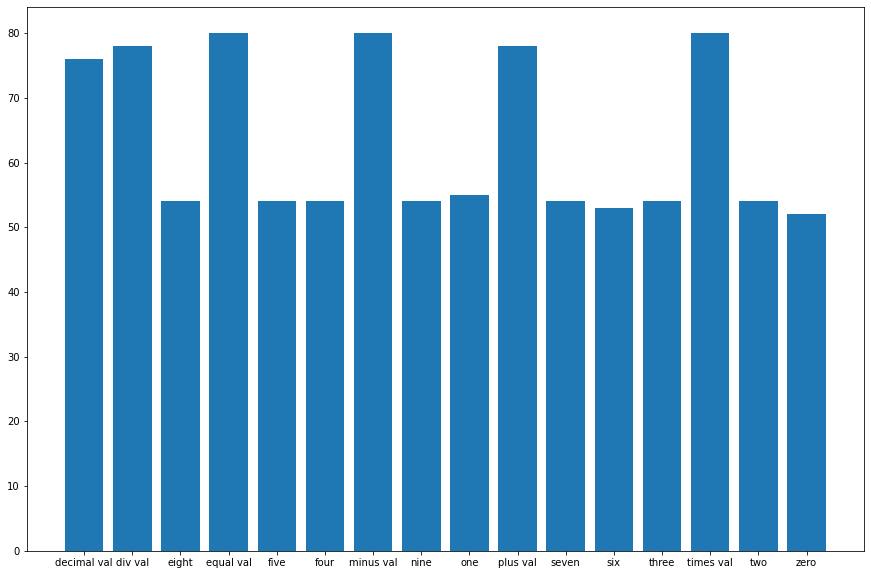

In [678]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.bar(list(eval_dataset.class_to_idx.keys()),list(dict(Counter(eval_dataset.targets)).values()))

{'decimal': 0, 'div': 1, 'eight': 2, 'equal': 3, 'five': 4, 'four': 5, 'minus': 6, 'nine': 7, 'one': 8, 'plus': 9, 'seven': 10, 'six': 11, 'three': 12, 'times': 13, 'two': 14, 'zero': 15}
{'decimal val': 0, 'div val': 1, 'eight': 2, 'equal val': 3, 'five': 4, 'four': 5, 'minus val': 6, 'nine': 7, 'one': 8, 'plus val': 9, 'seven': 10, 'six': 11, 'three': 12, 'times val': 13, 'two': 14, 'zero': 15}
shape torch.Size([1, 32, 32])
tensor([ 4,  0, 15,  7,  3,  8])


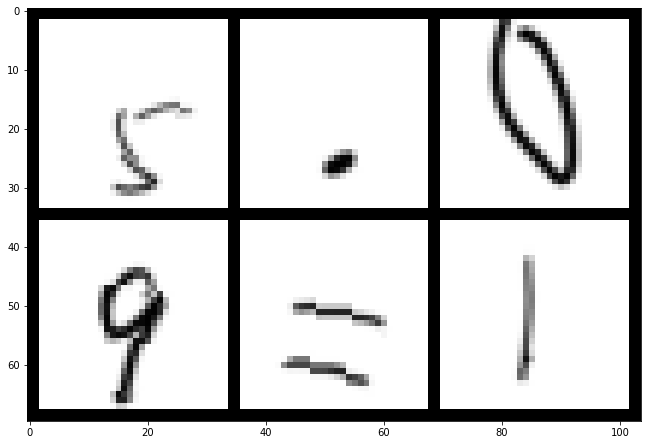

In [679]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=6,  shuffle=True) 
    batch = next(iter(loader))
    images, labels = batch
    print('shape', images[0].shape)
    grid = make_grid(images, nrow=3)
    plt.figure(figsize=(11, 11))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    print(labels)
print(train_dataset.class_to_idx), print(eval_dataset.class_to_idx)
show_transformed_images(train_dataset)

In [680]:
train_dataset[550][0].numpy().max(),  train_dataset[550][0].numpy().min()

(1.0, 0.019607844)

In [681]:
train_dataset.classes, len(train_dataset.classes)

(['decimal',
  'div',
  'eight',
  'equal',
  'five',
  'four',
  'minus',
  'nine',
  'one',
  'plus',
  'seven',
  'six',
  'three',
  'times',
  'two',
  'zero'],
 16)

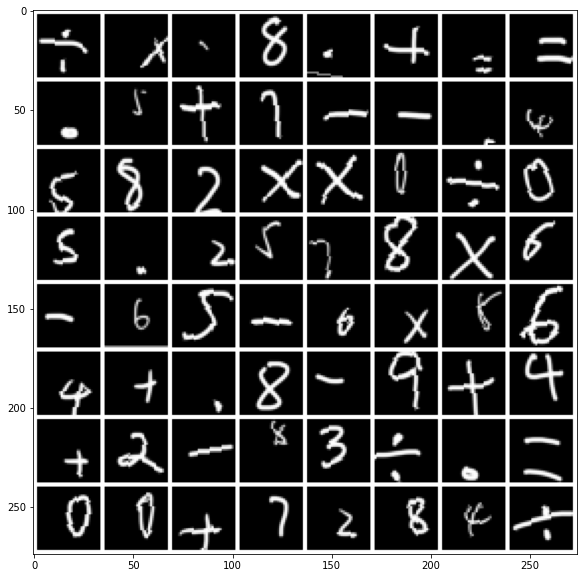

In [690]:
batch_size = 64
training_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
#     num_workers=2
)

validation_loader = torch.utils.data.DataLoader(
    eval_dataset,
    batch_size=batch_size,
    shuffle=True,
#     num_workers=2
)

# Class labels
classes = train_dataset.classes

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Extract a batch of 4 images
dataiter = iter(training_loader)
images, labels = dataiter.next()

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

In [691]:
# Default log_dir argument is "runs" - but it's good to be specific
# torch.utils.tensorboard.SummaryWriter is imported above
writer = SummaryWriter('runs/handwritten_digits_experiment_2')

# Write image data to TensorBoard log dir
writer.add_image('Four handwritten symbols Images', img_grid)
writer.flush()

# To view, start TensorBoard on the command line with:
#   tensorboard --logdir=runs
# ...and open a browser tab to http://localhost:6006/

In [692]:
model_input_shape, train_dataset[0][0].shape

((32, 32), torch.Size([1, 32, 32]))

In [ ]:
wandb.init(project="symbols", entity="kaizen")
wandb.config = {
  "learning_rate": 0.001,
  "epochs": 100,
  "batch_size": 128
}

In [800]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 5) # 28 * 28 * 4
        self.bn1 = nn.BatchNorm2d(4)
#         self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 5, 5) # 24 * 24 * 5
        self.bn2 = nn.BatchNorm2d(5)
        self.conv3 = nn.Conv2d(5, 6, 5) # 20 * 20 * 6
        self.bn3 = nn.BatchNorm2d(6)
        self.conv4 = nn.Conv2d(6, 8, 5) # 16 * 16 * 8
        self.bn4 = nn.BatchNorm2d(8)
        self.conv5 = nn.Conv2d(8, 12, 5) # 12 * 12 * 12
        self.bn5 = nn.BatchNorm2d(12)
        self.conv6 = nn.Conv2d(12, 16, 5) # 8 * 8 * 16
        self.bn6 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 16)
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight.data, 1)
            nn.init.constant_(m.bias.data, 0)
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight.data)
            nn.init.constant_(m.bias.data, 0)

    def forward(self, x):
        x = (x-0.5)*2
        x = self.conv1(x) # 28 * 28 * 4
        x = self.bn1(x)
        x = F.relu(x) # 28 * 28 * 4
#         x = self.pool(x)
        x = self.conv2(x) # 24 * 24 * 5
        x = self.bn2(x)
        x = F.relu(x)  # 24 * 24 * 5
        x = self.conv3(x) # 20 * 20 * 6
        x = self.bn3(x)
        x = F.relu(x)  # 20 * 20 * 6
        x = self.conv4(x) # 16 * 16 * 8
        x = self.bn4(x)
        x = F.relu(x)  # 16 * 16 * 8
        x = self.conv5(x) # 12 * 12 * 12
        x = self.bn5(x)
        x = F.relu(x)  # 12 * 12 * 12
        x = self.conv6(x) # 8 * 8 * 16
        x = self.bn6(x)
        x = F.relu(x)  # 8 * 8 * 16
        x = x.view(-1, 16 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = F.softmax(x, dim=-1)
        return x


net = Net()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.2, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
net(train_dataset[0][0][None, ...])

tensor([[0.0851, 0.0109, 0.0394, 0.0265, 0.0159, 0.0216, 0.1011, 0.0032, 0.4123,
         0.0410, 0.0074, 0.0080, 0.0093, 0.1539, 0.0276, 0.0368]],
       grad_fn=<SoftmaxBackward0>)

In [801]:
'batches',len(eval_dataset), len(validation_loader), len(training_loader)

('batches', 1010, 16, 119)

In [802]:
sample_val_batch, sample_val_result = next(iter(validation_loader))
sample_val_model_result = net(sample_val_batch)
print(sample_val_model_result.shape)
(sample_val_model_result.argmax(axis=1)==sample_val_result).sum()

torch.Size([64, 16])


tensor(2)

In [803]:
# print(len(validation_loader))
for epoch in range(25):  # loop over the dataset multiple times
    running_loss = 0.0
    print('epoch', epoch)
    for i, data in enumerate(training_loader, 0):
        # basic training loop
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        logits = nn.functional.one_hot(labels, len(classes)).float()
        loss = criterion(outputs, logits)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        print_frequency = 100
        if i % print_frequency == print_frequency-1:    # Every prinprint_frequency mini-batches...
            print('Batch {}'.format(i + 1))
            # Check against the validation set
            running_vloss = 0.0
            vaccuracy = 0.0

            net.train(False) # Don't need to track gradents for validation
            for j, vdata in enumerate(validation_loader, 0):
                vinputs, vlabels = vdata
                voutputs = net(vinputs)
                vlogits = nn.functional.one_hot(vlabels, len(classes)).float()
                vloss = criterion(voutputs, vlogits)
                running_vloss += vloss.item()
                vaccuracy += (voutputs.argmax(axis=1)==vlabels).sum()/len(vlabels)
            net.train(True) # Turn gradients back on for training

            avg_loss = running_loss / print_frequency
            avg_vloss = running_vloss / len(validation_loader)
            avg_vaccuracy = int(vaccuracy)/ len(validation_loader)
            print('avg_loss', avg_loss)
            print('avg_vloss', avg_vloss)
            print('avg_vaccuracy', avg_vaccuracy*100)
            print('lr', scheduler.get_lr())

            # Log the running loss averaged per batch
            writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : avg_loss, 'Validation' : avg_vloss },
                            epoch * len(training_loader) + i)
            writer.add_scalars('Validation Accuracy',
                            { 'Validation' : avg_vaccuracy },
                            epoch * len(training_loader) + i)

            running_loss = 0.0
    scheduler.step()
print('Finished Training')

writer.flush()

epoch 0
Batch 100
avg_loss 0.7176505589485168
avg_vloss 0.7121119014918804
avg_vaccuracy 25.0
lr [0.2]
epoch 1
Batch 100
avg_loss 0.7078059077262878
avg_vloss 0.7020227201282978
avg_vaccuracy 43.75
lr [0.16200000000000003]
epoch 2
Batch 100
avg_loss 0.7012077671289444
avg_vloss 0.6951909475028515
avg_vaccuracy 56.25
lr [0.14580000000000004]
epoch 3
Batch 100
avg_loss 0.6963452959060669
avg_vloss 0.6917408518493176
avg_vaccuracy 62.5
lr [0.13122000000000003]
epoch 4
Batch 100
avg_loss 0.6929505056142807
avg_vloss 0.6902584061026573
avg_vaccuracy 62.5
lr [0.11809800000000004]
epoch 5
Batch 100
avg_loss 0.6898313856124878
avg_vloss 0.6851925626397133
avg_vaccuracy 68.75
lr [0.10628820000000004]
epoch 6
Batch 100
avg_loss 0.6882099497318268
avg_vloss 0.6839545369148254
avg_vaccuracy 75.0
lr [0.09565938000000004]
epoch 7
Batch 100
avg_loss 0.6871299558877945
avg_vloss 0.6810062937438488
avg_vaccuracy 81.25
lr [0.08609344200000005]
epoch 8
Batch 100
avg_loss 0.6843900328874588
avg_vloss 0.68

In [772]:
def inference(sample):
    image, label = sample
    res = net(image[None, ...])
    print(res.argmax(axis=1))
    print(label)
inference(eval_dataset[500])

tensor([7])
7


In [773]:
x = torch.randn(1, 1, model_input_shape[0], model_input_shape[0], requires_grad=True)
x.shape

torch.Size([1, 1, 32, 32])

In [774]:
torch.onnx.export(net, x, 'conv_v3.onnx', input_names=['input'], output_names=['output'])

In [775]:
train_dataset.class_to_idx, eval_dataset.class_to_idx

({'decimal': 0,
  'div': 1,
  'eight': 2,
  'equal': 3,
  'five': 4,
  'four': 5,
  'minus': 6,
  'nine': 7,
  'one': 8,
  'plus': 9,
  'seven': 10,
  'six': 11,
  'three': 12,
  'times': 13,
  'two': 14,
  'zero': 15},
 {'decimal val': 0,
  'div val': 1,
  'eight': 2,
  'equal val': 3,
  'five': 4,
  'four': 5,
  'minus val': 6,
  'nine': 7,
  'one': 8,
  'plus val': 9,
  'seven': 10,
  'six': 11,
  'three': 12,
  'times val': 13,
  'two': 14,
  'zero': 15})